In [1]:
import pandas as pd
import numpy as np
import nltk
import os
import re

from wasabi import msg
from bs4 import BeautifulSoup

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

TOKENIZER = nltk.tokenize.word_tokenize

plt.rcParams['font.size'] = 11
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = 'Arial'

In [2]:
# hyphen pattern
pat_line_break = re.compile(r'¬\s+', re.UNICODE)
# trailing hyphen pattern (does not delimit words)
pat_trailing_line_break = re.compile(r'¬', re.UNICODE)
# specials characters used by annotators, but we're ignoring them
pat_unreadable = re.compile(r'#|@', re.UNICODE)

## Count chronicles directly from Surfdrive

In [11]:
full_corpus = 'path-to/Status definitieve corpus_2.xlsx'

corpus = pd.read_excel(full_corpus, sheet_name='Alle kronieken')
corpus = corpus[['Batch', 'Call Number', 'Transcriptie klaar', 'Geannoteerd', 'Geannoteerd (bronnen van informatie)', 'Datums genormaliseerd']]
corpus = corpus[corpus['Call Number'].isna() == False]
corpus = corpus[corpus['Transcriptie klaar'].isin(['Ja', 'n.v.t.'])]
corpus['year'] = corpus['Call Number'].str[:4].astype(int)
corpus['call_nr_clean'] = corpus['Call Number'].str[:14]
corpus['cut'] = pd.cut(corpus['year'], np.arange(1475, 1925, 25))
corpus['cut'] = corpus['cut'].astype(str)
corpus['cut'] = corpus['cut'].str[1:-1]
corpus['cut'] = corpus['cut'].str.replace(', ', '–')

In [12]:
corpus.shape

(308, 9)

In [19]:
corpus_dbnl = corpus[corpus['Batch'].isin(['DBNL', 'DBNL*', 'Transkr', 'Transkr/DBNL'])]
corpus_dbnl['call_nr_clean'].nunique()

98

In [18]:
corpus['call_nr_clean'].nunique()

204

In [14]:
corpus.groupby('Geannoteerd (bronnen van informatie)')['call_nr_clean'].count()

Geannoteerd (bronnen van informatie)
Ja                           50
Ja (?)                        2
gedeelte                     36
gedeelte (?)                 14
gedeelte (buiten bereik)      3
nee                         203
Name: call_nr_clean, dtype: int64

In [9]:
corpus['city'] = corpus['Call Number'].str[5:9]

In [6]:
corpus['author'] = corpus['Call Number'].str[10:14]

In [8]:
corpus.groupby('Transcriptie klaar')['call_nr_clean'].nunique()

Transcriptie klaar
Ja        107
n.v.t.     97
Name: call_nr_clean, dtype: int64

In [9]:
corpus_annotated = corpus[corpus['Geannoteerd'] == 'Ja']
df_annotated = corpus_annotated.groupby('cut')['Call Number', 'call_nr_clean'].nunique().reset_index()

/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/ipykernel_8875/3861526653.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_annotated = corpus_annotated.groupby('cut')['Call Number', 'call_nr_clean'].nunique().reset_index()


In [11]:
corpus_annotated.shape

(196, 8)

In [14]:
corpus_annotated.shape

(196, 8)

In [7]:
df_full = corpus.groupby('cut')['Call Number', 'call_nr_clean'].nunique().reset_index()

corpus_events = corpus[corpus['Datums genormaliseerd'] == 'Yes']
df_events = corpus_events.groupby('cut')['Call Number', 'call_nr_clean'].nunique().reset_index()

#corpus_sources = corpus[corpus['Geannoteerd (bronnen van informatie)'] != 'nee']
corpus_sources = corpus[corpus['Geannoteerd (bronnen van informatie)'].isin(['Ja', 'gedeelte'])]
df_sources = corpus_sources.groupby('cut')['Call Number', 'call_nr_clean'].nunique().reset_index()

/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/ipykernel_88234/1218534313.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_full = corpus.groupby('cut')['Call Number', 'call_nr_clean'].nunique().reset_index()
/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/ipykernel_88234/1218534313.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_events = corpus_events.groupby('cut')['Call Number', 'call_nr_clean'].nunique().reset_index()
/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/ipykernel_88234/1218534313.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_sources = corpus_sources.groupby('cut')['Call Number', 'call_nr_clean'].nunique().reset_index()


In [8]:
corpus_sources.shape

(86, 8)

In [11]:
corpus_sources['call_nr_clean'].nunique()

65

In [19]:
corpus_events.shape

(184, 8)

## Count tokens from XML files

In [3]:
data_dir = 'path-to/corpus_230811/corpus_230811_full'

xml_paths = [os.path.join(data_dir, path) for path in os.listdir(data_dir) if path.endswith('.xml')]
rows = []

for path in tqdm(xml_paths):
    try:
        d_dict = {}
        with open(path, 'r', encoding='utf-8') as f_in:
            soup = BeautifulSoup(f_in, 'lxml')

        title_tags = soup.find_all('title')
        call_nr = title_tags[0].get_text()
        plain = []
        increments = soup.find_all('l')
        for text in increments:
            txt = text.get_text()
            plain.append(txt)
        plain = ' '.join(plain)
        while re.search(pat_line_break, plain):
            plain = re.sub(pat_line_break, '', plain)
        while re.search(pat_trailing_line_break, plain):
            plain = re.sub(pat_trailing_line_break, '', plain)
        while re.search(pat_unreadable, plain):
            plain = re.sub(pat_unreadable, '', plain)
        tokens = TOKENIZER(plain)
        d_dict['call_nr'] = call_nr
        d_dict['call_nr_clean'] = call_nr[:14]
        d_dict['year'] = int(call_nr[:4])
        d_dict['tokens'] = len(tokens)
        rows.append(d_dict)
    except:
        msg.fail(f'file failed: {path}')
    

  0%|          | 0/309 [00:00<?, ?it/s]

/Users/alielassche/opt/anaconda3/lib/python3.9/site-packages/bs4/builder/__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [4]:
full = pd.DataFrame(rows)

In [5]:
full.sum()

call_nr          1795_Mege_Loef1759_Hoeg_Kemp1697_Leeu_Vitr_021...
call_nr_clean    1795_Mege_Loef1759_Hoeg_Kemp1697_Leeu_Vitr1574...
year                                                        536388
tokens                                                    23871380
dtype: object

In [15]:
corpus_sources.merge(full, left_on='Call Number', right_on='call_nr').sum()

/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/ipykernel_8875/2000825937.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  corpus_sources.merge(full, left_on='Call Number', right_on='call_nr').sum()


Call Number                             1558_Bosc_Cupe1568_Gent_Vaer1574_Antw_Ano11574...
Transcriptie klaar                      n.v.t.n.v.t.n.v.t.n.v.t.n.v.t.n.v.t.Jan.v.t.Ja...
Geannoteerd                             JaJaJaJaJaJaJaJaJaJaJaJaJaJaJaJaJaJaJaJaJaJaJa...
Geannoteerd (bronnen van informatie)    JagedeelteJaJagedeeltegedeelteJagedeeltegedeel...
year_x                                                                             145781
call_nr_clean_x                         1558_Bosc_Cupe1568_Gent_Vaer1574_Antw_Ano11574...
cut                                     1550–15751550–15751550–15751550–15751550–15751...
call_nr                                 1558_Bosc_Cupe1568_Gent_Vaer1574_Antw_Ano11574...
call_nr_clean_y                         1558_Bosc_Cupe1568_Gent_Vaer1574_Antw_Ano11574...
year_y                                                                             145781
tokens                                                                            6640985
dtype: obj

In [5]:
full_grouped = full.groupby(['call_nr_clean', 'year'])['tokens'].sum().reset_index()

In [66]:
full_grouped.to_csv('../full_grouped.csv')

In [67]:
full_grouped.sum()

call_nr_clean    1499_Rott_Jans1507_Beek_Trec1509_Zier_Anon1526...
year                                                        354234
tokens                                                    23871380
dtype: object

In [23]:
metadata_corpus = '/Users/alielassche/surfdrive/Shared/[Chronicles] team proceedings/Metadata kronieken/Chronicles_metadata.xlsx'

metadata = pd.read_excel(metadata_corpus, sheet_name='Chronicles')
metadata = metadata[['Call_Number']]

In [24]:
metadata.merge(full[['call_nr', 'tokens']], left_on='Call_Number', right_on='call_nr', how='outer').fillna(0).to_csv('wordcount.csv')

In [7]:
events = pd.DataFrame(rows)
events_grouped = events.groupby(['call_nr_clean', 'year'])['tokens'].sum().reset_index()

In [8]:
events_grouped.to_csv('../events_grouped.csv')

In [9]:
events_grouped = pd.read_csv('../events_grouped.csv', sep=',', index_col=0)
events_grouped.head()

,call_nr_clean,year,tokens
0,1499_Rott_Jans,1499,18553
1,1507_Beek_Trec,1507,61128
2,1509_Zier_Anon,1509,4091
3,1526_Zwol_Stee,1526,18332
4,1567_Amst_Bies,1567,12046


In [13]:
events_grouped.sum()

call_nr_clean    1499_Rott_Jans1507_Beek_Trec1509_Zier_Anon1526...
year                                                        218236
tokens                                                    11316011
dtype: object

## Visualizations

### Full corpus

/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/ipykernel_57111/223663108.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(labels=df_full['cut'], rotation = 45)


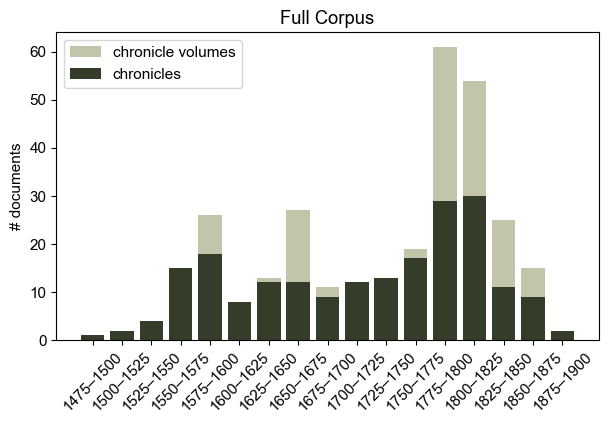

In [41]:
fig, axs = plt.subplots(figsize=(7, 4))

axs.bar(df_full['cut'], df_full['Call Number'], color='#C2C5AA')
axs.bar(df_full['cut'], df_full['call_nr_clean'], color='#333D29')
axs.set_title('Full Corpus')
axs.set_ylabel('# documents')
axs.set_xlabel('')
axs.set_xticklabels(labels=df_full['cut'], rotation = 45)
axs.legend(['chronicle volumes', 'chronicles'])

plt.savefig('../images/full_corpus_chronicles.pdf', bbox_inches = 'tight')

### Topic Corpus

/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/ipykernel_57111/1229935695.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(labels=df_annotated['cut'], rotation = 45)


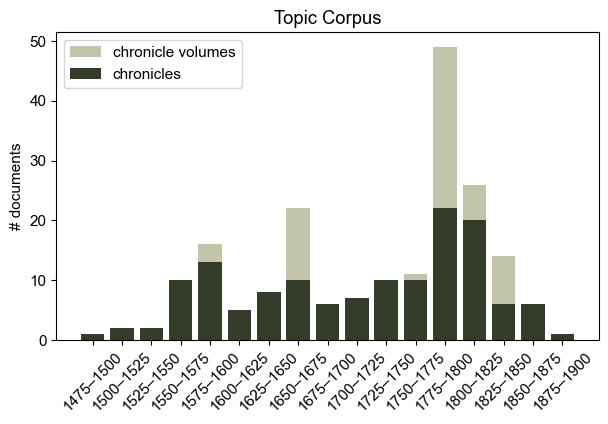

In [40]:
fig, axs = plt.subplots(figsize=(7, 4))

axs.bar(df_annotated['cut'], df_annotated['Call Number'], color='#C2C5AA')
axs.bar(df_annotated['cut'], df_annotated['call_nr_clean'], color='#333D29')
axs.set_title('Topic Corpus')
#axs.set_title('Distribution of chronicles in the corpus')
axs.set_ylabel('# documents')
axs.set_xlabel('')
axs.set_xticklabels(labels=df_annotated['cut'], rotation = 45)
axs.legend(['chronicle volumes', 'chronicles'])

plt.savefig('../images/topic_corpus_chronicles.pdf', bbox_inches = 'tight')

### Source Corpus

/var/folders/h3/_6gy9k2x3tgbm9pj_grj43rr0000gn/T/ipykernel_88234/769916915.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels(labels=df_sources['cut'], rotation = 45)


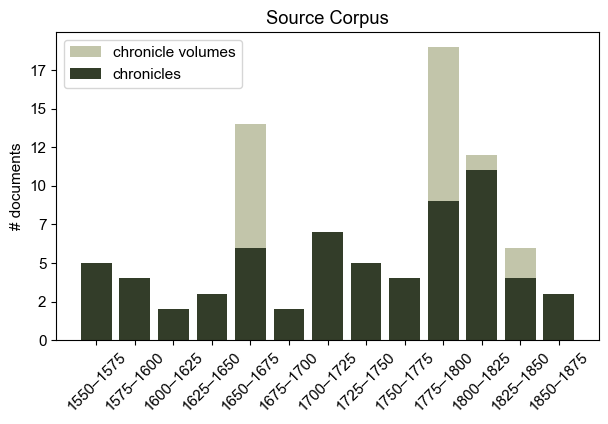

In [12]:
fig, axs = plt.subplots(figsize=(7, 4))

axs.bar(df_sources['cut'], df_sources['Call Number'], color='#C2C5AA')
axs.bar(df_sources['cut'], df_sources['call_nr_clean'], color='#333D29')
axs.set_title('Source Corpus')
axs.set_ylabel('# documents')
axs.set_xlabel('')
axs.set_xticklabels(labels=df_sources['cut'], rotation = 45)
axs.legend(['chronicle volumes', 'chronicles'])
axs.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: '{:d}'.format(int(x))))

plt.savefig('../images/source_corpus_chronicles.pdf', bbox_inches = 'tight')

### Chronicle length

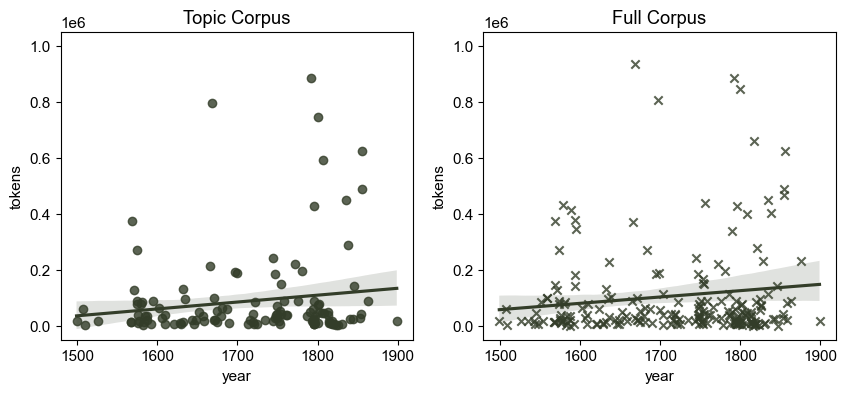

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10,4), sharex=True)

sns.regplot(ax=axs[0], x='year', y='tokens', data=events_grouped, marker='o', scatter_kws = {'color': '#333D29'}, line_kws = {'color': '#333D29'})
sns.regplot(ax=axs[1], x='year', y='tokens', data=full_grouped, marker='x', scatter_kws = {'color': '#333D29'}, line_kws = {'color': '#333D29'})
axs[0].set_title('Topic Corpus')
axs[1].set_title('Full Corpus')
axs[0].set_ylim(-50000,1050000)
axs[1].set_ylim(-50000,1050000)
#axs.set_title('Number of tokens per chronicle in the Topic Corpus')
axs[0].set_ylabel('tokens')
#axs[1].set_ylabel('tokens')
axs[0].set_xlabel('year')
axs[1].set_xlabel('year')
#axs[0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#axs[1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.savefig('../images/chronicles_tokens_topic_full.pdf', bbox_inches='tight')

In [47]:
max_index = full_grouped['tokens'].idxmax()
full_grouped.loc[max_index]

call_nr_clean    1807_Leuv_Pelc
year                       1807
tokens                  2159359
Name: 162, dtype: object

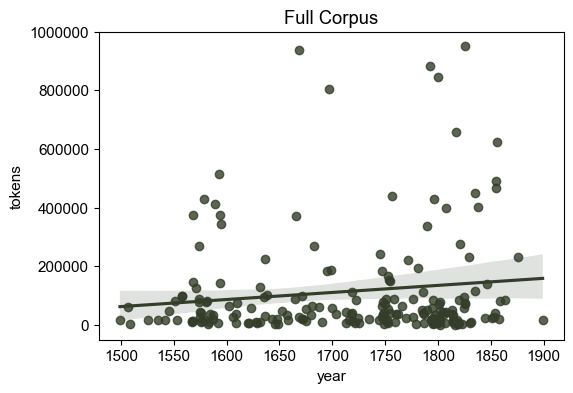

In [7]:
fig, axs = plt.subplots(figsize=(6,4))

sns.regplot(x='year', y='tokens', data=full_grouped, marker='o', scatter_kws = {'color': '#333D29'}, line_kws = {'color': '#333D29'})
axs.set_ylim(-50000,1000000)
axs.ticklabel_format(useOffset=False, style='plain')
axs.set_title('Full Corpus')
axs.set_ylabel('tokens')
#axs[1].set_ylabel('tokens')
axs.set_xlabel('year')
#axs[0].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
#axs[1].get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

plt.savefig('../images/chronicles_tokens_full.pdf', bbox_inches='tight')